## import

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import albumentations as A
import torch
import torch.nn.functional as F
import torchinfo
import torchvision.transforms as T
from albumentations.pytorch.transforms import ToTensorV2
from torch.utils.data import DataLoader
from torchlake.common.constants import VOC_CLASS_NAMES
from torchlake.common.utils.convert import img_tensor_to_np
from torchlake.common.utils.image import decode_segmap, load_image
from torchlake.common.utils.plot import plot_grids
from torchlake.common.utils.platform import get_file_size, get_num_workers
from torchlake.common.controller.trainer import ClassificationTrainer
from torchlake.common.controller.evaluator import ClassificationEvaluator
from torchlake.common.datasets.voc import VOCSegmentation
from torchlake.common.datasets.voc.constants import LABEL_COLORS
from torchlake.semantic_segmentation.models.deeplabv2 import DeepLabV2, deeplab_v2_style_vgg
from torchlake.common.models import VGGFeatureExtractor

from tqdm import tqdm

d:\research\pytorch-implementations\gits\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# setting

In [2]:
artifacts_path = Path("../../artifacts/deeplabv2")
artifacts_path.mkdir(exist_ok=True)

data_path = Path("../../data")

In [3]:
DEVICE = torch.device("cuda:0")

# data

In [4]:
BATCH_SIZE = 16
TRAIN_IMAGE_SIZE = 321 # 32k-31
TEST_IMAGE_SIZE = 513 # 32k-31
NUM_CLASS = len(VOC_CLASS_NAMES)

In [5]:
class DownScaleTransform(torch.nn.Module):
    def __init__(self, scale_factor: float):
        super().__init__()
        self.scale_factor = scale_factor

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return torch.nn.functional.interpolate(
            x.expand(1, 1, *x.shape),
            size=TRAIN_IMAGE_SIZE // self.scale_factor + 1,
            mode='nearest',
        ).squeeze()

In [6]:
train_transform = A.Compose(
    [
        A.HorizontalFlip(),
        A.Resize(TRAIN_IMAGE_SIZE, TRAIN_IMAGE_SIZE),
        A.Normalize(0, 1),  # in feature extractor
        ToTensorV2(),
    ]
)

train_label_transform = T.Compose(
    [
        DownScaleTransform(8),
    ]
)

test_transform = A.Compose(
    [
        A.Resize(TEST_IMAGE_SIZE, TEST_IMAGE_SIZE),
        A.Normalize(0, 1),  # in feature extractor
        ToTensorV2(),
    ]
)

In [7]:
train_dataset = VOCSegmentation(
    data_path.as_posix(),
    year="2012",
    transform=train_transform,
    label_transform=train_label_transform,
)

test_dataset = VOCSegmentation(
    data_path.as_posix(),
    year="2007",
    transform=test_transform,
)

In [8]:
NUM_WORKERS = get_num_workers()

In [9]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    num_workers=NUM_WORKERS,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE // 2,
    num_workers=NUM_WORKERS,
)

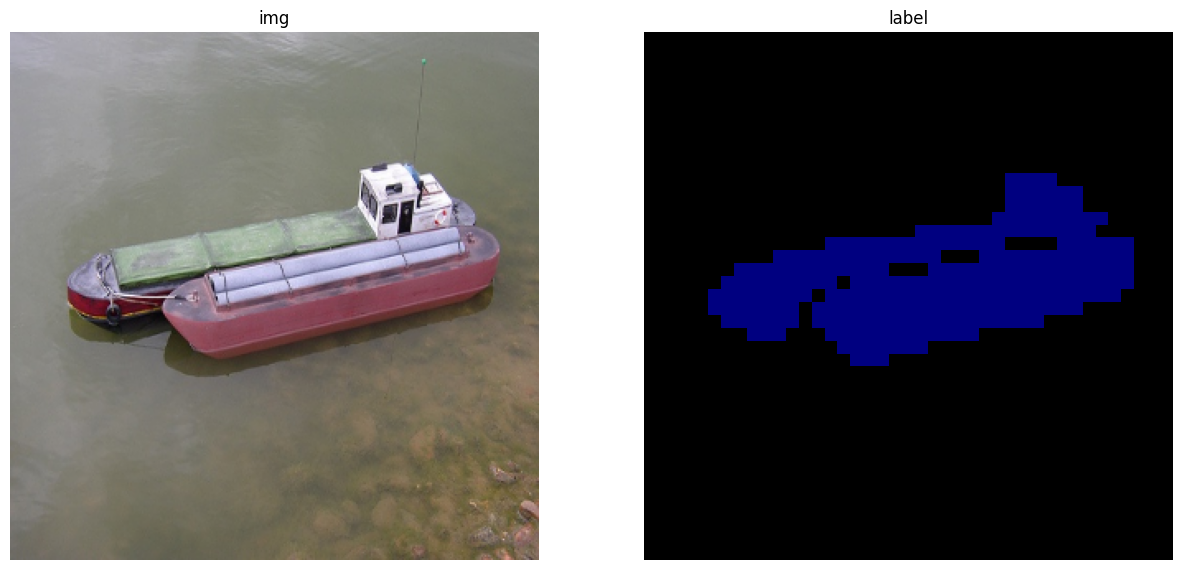

In [10]:
interest_pic = 102
img, label = train_dataset[interest_pic]

plot_grids(
    [
        img_tensor_to_np(img),
        decode_segmap(label, LABEL_COLORS),
    ],
    ["img", "label"],
    1,
    2,
    figsize=(15, 7),
)

# model

In [11]:
backbone = deeplab_v2_style_vgg("vgg16", trainable=True)
model = DeepLabV2(backbone, output_size=NUM_CLASS + 1).to(DEVICE)

In [12]:
torchinfo.summary(model)

Layer (type:depth-idx)                                  Param #
DeepLabV2                                               --
├─VGGFeatureExtractor: 1-1                              --
│    └─Sequential: 2-1                                  --
│    │    └─Conv2d: 3-1                                 1,792
│    │    └─ReLU: 3-2                                   --
│    │    └─Conv2d: 3-3                                 36,928
│    │    └─ReLU: 3-4                                   --
│    │    └─MaxPool2d: 3-5                              --
│    │    └─Conv2d: 3-6                                 73,856
│    │    └─ReLU: 3-7                                   --
│    │    └─Conv2d: 3-8                                 147,584
│    │    └─ReLU: 3-9                                   --
│    │    └─MaxPool2d: 3-10                             --
│    │    └─Conv2d: 3-11                                295,168
│    │    └─ReLU: 3-12                                  --
│    │    └─Conv2d: 3-13      

# train

In [13]:
EPOCHS = 30

In [14]:
trainer = ClassificationTrainer(EPOCHS, DEVICE)
trainer.recorder.increment_data_size(len(train_dataset))

In [15]:
criterion = trainer.get_criterion(NUM_CLASS)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [16]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, threshold=.05 ,threshold_mode ='rel')

In [17]:
training_loss = trainer.run(train_loader, model, optimizer, criterion, scheduler)

Enable AMP: False
Training...


100%|██████████| 182/182 [02:01<00:00,  1.50it/s]


------------------------------------
Epoch 1
------------------------------------
total: 4.7783e-02 (0.00%)


100%|██████████| 182/182 [01:37<00:00,  1.87it/s]


------------------------------------
Epoch 2
------------------------------------
total: 2.5503e-02 (-47.00%)


100%|██████████| 182/182 [01:34<00:00,  1.93it/s]


------------------------------------
Epoch 3
------------------------------------
total: 1.9842e-02 (-22.00%)


100%|██████████| 182/182 [02:12<00:00,  1.38it/s]


------------------------------------
Epoch 4
------------------------------------
total: 1.6373e-02 (-17.00%)


100%|██████████| 182/182 [01:52<00:00,  1.62it/s]


------------------------------------
Epoch 5
------------------------------------
total: 1.3524e-02 (-17.00%)


100%|██████████| 182/182 [01:27<00:00,  2.08it/s]


------------------------------------
Epoch 6
------------------------------------
total: 1.1000e-02 (-19.00%)


100%|██████████| 182/182 [01:54<00:00,  1.59it/s]


------------------------------------
Epoch 7
------------------------------------
total: 1.1022e-02 (0.00%)


100%|██████████| 182/182 [02:06<00:00,  1.44it/s]


------------------------------------
Epoch 8
------------------------------------
total: 9.6067e-03 (-13.00%)


100%|██████████| 182/182 [01:47<00:00,  1.70it/s]


------------------------------------
Epoch 9
------------------------------------
total: 9.1637e-03 (-5.00%)


100%|██████████| 182/182 [01:56<00:00,  1.56it/s]


------------------------------------
Epoch 10
------------------------------------
total: 8.2363e-03 (-10.00%)


100%|██████████| 182/182 [02:10<00:00,  1.39it/s]


------------------------------------
Epoch 11
------------------------------------
total: 6.8404e-03 (-17.00%)


100%|██████████| 182/182 [02:07<00:00,  1.42it/s]


------------------------------------
Epoch 12
------------------------------------
total: 6.1602e-03 (-10.00%)


100%|██████████| 182/182 [02:17<00:00,  1.33it/s]


------------------------------------
Epoch 13
------------------------------------
total: 5.6359e-03 (-9.00%)


100%|██████████| 182/182 [02:15<00:00,  1.34it/s]


------------------------------------
Epoch 14
------------------------------------
total: 5.3344e-03 (-5.00%)


100%|██████████| 182/182 [02:16<00:00,  1.33it/s]


------------------------------------
Epoch 15
------------------------------------
total: 5.1535e-03 (-3.00%)


100%|██████████| 182/182 [02:16<00:00,  1.33it/s]


------------------------------------
Epoch 16
------------------------------------
total: 5.0456e-03 (-2.00%)


100%|██████████| 182/182 [02:16<00:00,  1.33it/s]


------------------------------------
Epoch 17
------------------------------------
total: 4.9527e-03 (-2.00%)


100%|██████████| 182/182 [02:16<00:00,  1.34it/s]


------------------------------------
Epoch 18
------------------------------------
total: 4.8612e-03 (-2.00%)


100%|██████████| 182/182 [02:07<00:00,  1.43it/s]


------------------------------------
Epoch 19
------------------------------------
total: 4.7337e-03 (-3.00%)


100%|██████████| 182/182 [02:19<00:00,  1.30it/s]


------------------------------------
Epoch 20
------------------------------------
total: 4.5569e-03 (-4.00%)


100%|██████████| 182/182 [02:18<00:00,  1.32it/s]


------------------------------------
Epoch 21
------------------------------------
total: 4.3997e-03 (-3.00%)


100%|██████████| 182/182 [02:07<00:00,  1.43it/s]


------------------------------------
Epoch 22
------------------------------------
total: 6.6348e-03 (51.00%)


100%|██████████| 182/182 [01:27<00:00,  2.09it/s]


------------------------------------
Epoch 23
------------------------------------
total: 2.2773e-02 (243.00%)


100%|██████████| 182/182 [01:27<00:00,  2.09it/s]


------------------------------------
Epoch 24
------------------------------------
total: 7.6955e-03 (-66.00%)


100%|██████████| 182/182 [01:27<00:00,  2.09it/s]


------------------------------------
Epoch 25
------------------------------------
total: 4.9505e-03 (-36.00%)


100%|██████████| 182/182 [01:27<00:00,  2.08it/s]


------------------------------------
Epoch 26
------------------------------------
total: 4.2015e-03 (-15.00%)


100%|██████████| 182/182 [01:27<00:00,  2.09it/s]


------------------------------------
Epoch 27
------------------------------------
total: 3.8433e-03 (-9.00%)


100%|██████████| 182/182 [01:27<00:00,  2.09it/s]


------------------------------------
Epoch 28
------------------------------------
total: 3.5501e-03 (-8.00%)


100%|██████████| 182/182 [01:27<00:00,  2.09it/s]


------------------------------------
Epoch 29
------------------------------------
total: 3.3824e-03 (-5.00%)


100%|██████████| 182/182 [01:27<00:00,  2.08it/s]

------------------------------------
Epoch 30
------------------------------------
total: 3.2626e-03 (-4.00%)


In [17]:
training_loss = trainer.run(train_loader, model, optimizer, criterion, scheduler)

Enable AMP: False
Training...


100%|██████████| 182/182 [06:23<00:00,  2.11s/it]


------------------------------------
Epoch 1
------------------------------------
total: 5.5489e-02 (0.00%)


100%|██████████| 182/182 [02:29<00:00,  1.22it/s]


------------------------------------
Epoch 2
------------------------------------
total: 2.8836e-02 (-48.00%)


100%|██████████| 182/182 [02:26<00:00,  1.24it/s]


------------------------------------
Epoch 3
------------------------------------
total: 2.1515e-02 (-25.00%)


100%|██████████| 182/182 [02:24<00:00,  1.26it/s]


------------------------------------
Epoch 4
------------------------------------
total: 1.6777e-02 (-22.00%)


100%|██████████| 182/182 [19:06<00:00,  6.30s/it]   


------------------------------------
Epoch 5
------------------------------------
total: 1.4333e-02 (-15.00%)


100%|██████████| 182/182 [02:24<00:00,  1.26it/s]


------------------------------------
Epoch 6
------------------------------------
total: 1.2564e-02 (-12.00%)


100%|██████████| 182/182 [02:27<00:00,  1.24it/s]


------------------------------------
Epoch 7
------------------------------------
total: 1.0043e-02 (-20.00%)


100%|██████████| 182/182 [02:29<00:00,  1.22it/s]


------------------------------------
Epoch 8
------------------------------------
total: 8.9048e-03 (-11.00%)


100%|██████████| 182/182 [02:32<00:00,  1.19it/s]


------------------------------------
Epoch 9
------------------------------------
total: 9.3782e-03 (5.00%)


100%|██████████| 182/182 [02:29<00:00,  1.22it/s]


------------------------------------
Epoch 10
------------------------------------
total: 8.2898e-03 (-12.00%)


100%|██████████| 182/182 [02:37<00:00,  1.16it/s]


------------------------------------
Epoch 11
------------------------------------
total: 7.1990e-03 (-13.00%)


100%|██████████| 182/182 [02:26<00:00,  1.24it/s]


------------------------------------
Epoch 12
------------------------------------
total: 6.7055e-03 (-7.00%)


100%|██████████| 182/182 [02:23<00:00,  1.27it/s]


------------------------------------
Epoch 13
------------------------------------
total: 6.0258e-03 (-10.00%)


100%|██████████| 182/182 [02:20<00:00,  1.30it/s]


------------------------------------
Epoch 14
------------------------------------
total: 5.6127e-03 (-7.00%)


100%|██████████| 182/182 [02:22<00:00,  1.27it/s]


------------------------------------
Epoch 15
------------------------------------
total: 5.4061e-03 (-4.00%)


100%|██████████| 182/182 [02:23<00:00,  1.27it/s]


------------------------------------
Epoch 16
------------------------------------
total: 5.3330e-03 (-1.00%)


100%|██████████| 182/182 [02:25<00:00,  1.25it/s]


------------------------------------
Epoch 17
------------------------------------
total: 5.2341e-03 (-2.00%)


100%|██████████| 182/182 [02:21<00:00,  1.29it/s]


------------------------------------
Epoch 18
------------------------------------
total: 6.7722e-03 (29.00%)


100%|██████████| 182/182 [02:27<00:00,  1.24it/s]


------------------------------------
Epoch 19
------------------------------------
total: 1.4513e-02 (114.00%)


100%|██████████| 182/182 [02:24<00:00,  1.26it/s]


------------------------------------
Epoch 20
------------------------------------
total: 6.0374e-03 (-58.00%)


100%|██████████| 182/182 [02:26<00:00,  1.24it/s]


------------------------------------
Epoch 21
------------------------------------
total: 4.9363e-03 (-18.00%)


100%|██████████| 182/182 [02:27<00:00,  1.23it/s]


------------------------------------
Epoch 22
------------------------------------
total: 4.5445e-03 (-8.00%)


100%|██████████| 182/182 [02:31<00:00,  1.20it/s]


------------------------------------
Epoch 23
------------------------------------
total: 4.1490e-03 (-9.00%)


100%|██████████| 182/182 [02:28<00:00,  1.23it/s]


------------------------------------
Epoch 24
------------------------------------
total: 3.9102e-03 (-6.00%)


100%|██████████| 182/182 [02:24<00:00,  1.26it/s]


------------------------------------
Epoch 25
------------------------------------
total: 3.7882e-03 (-3.00%)


100%|██████████| 182/182 [02:26<00:00,  1.24it/s]


------------------------------------
Epoch 26
------------------------------------
total: 3.6987e-03 (-2.00%)


100%|██████████| 182/182 [02:26<00:00,  1.24it/s]


------------------------------------
Epoch 27
------------------------------------
total: 3.6144e-03 (-2.00%)


100%|██████████| 182/182 [02:20<00:00,  1.29it/s]


------------------------------------
Epoch 28
------------------------------------
total: 3.6370e-03 (1.00%)


100%|██████████| 182/182 [02:19<00:00,  1.30it/s]


------------------------------------
Epoch 29
------------------------------------
total: 3.5695e-03 (-2.00%)


100%|██████████| 182/182 [02:22<00:00,  1.28it/s]

------------------------------------
Epoch 30
------------------------------------
total: 3.5370e-03 (-1.00%)


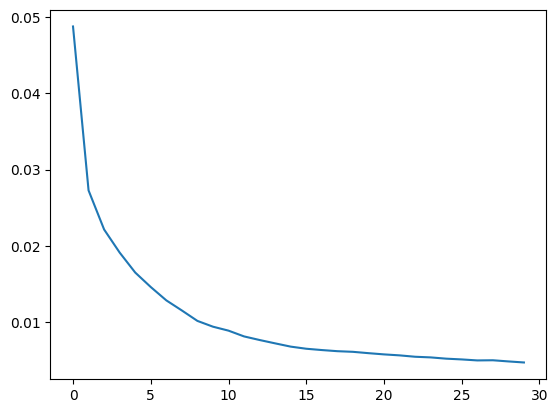

In [19]:
plt.plot(training_loss)

In [ ]:
model_path = artifacts_path.joinpath('deeplabv2.vgg16.pth')

In [23]:
torch.save(model.state_dict(), model_path)

In [24]:
get_file_size(model_path)

'144.51MiB'

In [14]:
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

# inference

### mIOU

In [15]:
from torchmetrics.classification import jaccard

metric = jaccard.MulticlassJaccardIndex(NUM_CLASS + 1, average=None)

In [16]:
evaluator = ClassificationEvaluator(NUM_CLASS + 1, DEVICE)

In [17]:
metric = evaluator.run(test_loader, model, metric)

100%|██████████| 79/79 [00:28<00:00,  2.77it/s]


In [21]:
for class_name, value in zip(VOC_CLASS_NAMES, metric.compute()[1:].mul(100).round().tolist()):
    print("{:<15}: {:<5}".format(class_name, value / 100))

print("----------------------")
print("{:<15}: {:<5}".format("total", metric.compute()[1:].mean().mul(100).round().item()/100))

aeroplane      : 0.75 
bicycle        : 0.43 
bird           : 0.75 
boat           : 0.65 
bottle         : 0.61 
bus            : 0.73 
car            : 0.73 
cat            : 0.78 
chair          : 0.43 
cow            : 0.75 
diningtable    : 0.72 
dog            : 0.67 
horse          : 0.66 
motorbike      : 0.72 
person         : 0.76 
pottedplant    : 0.39 
sheep          : 0.76 
sofa           : 0.61 
train          : 0.76 
tvmonitor      : 0.64 
----------------------
total          : 0.67 


(<Figure size 640x480 with 1 Axes>, <Axes: ylabel='MulticlassJaccardIndex'>)

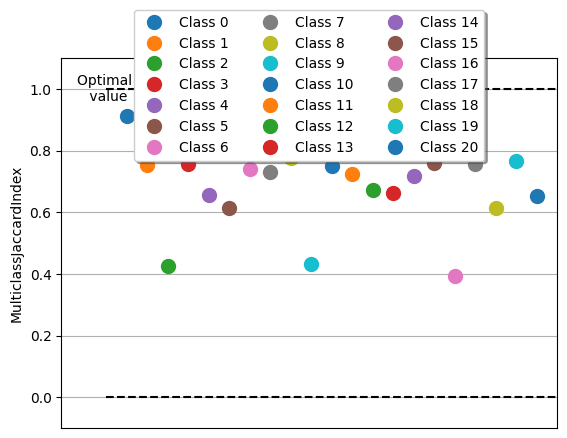

In [19]:
metric.plot()

### for image in dataset

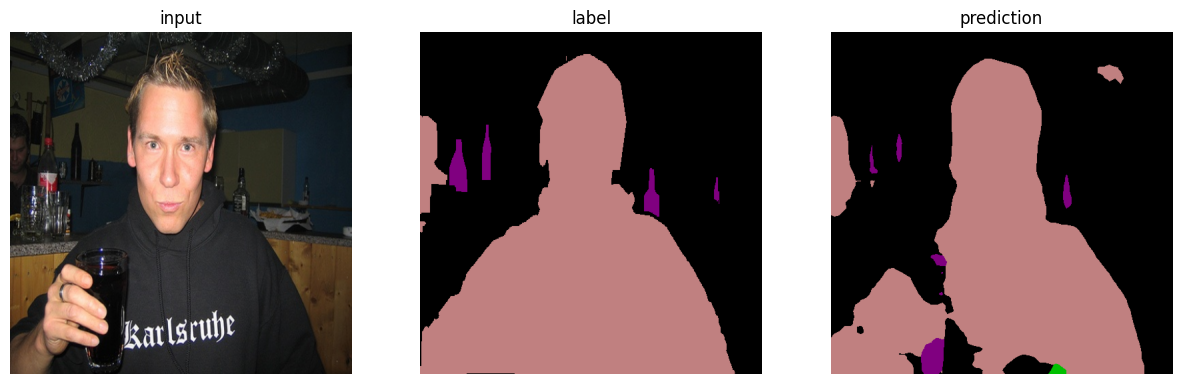

In [20]:
interest_pic = 10

model.eval()
with torch.no_grad():
    target_img, target_label = test_dataset[interest_pic]

    output = model(target_img.unsqueeze(0).to(DEVICE))
    output = output.squeeze(0).permute(1, 2, 0).argmax(dim=2).detach().cpu()

plot_grids(
    [
        img_tensor_to_np(target_img),
        decode_segmap(target_label.numpy(), LABEL_COLORS),
        decode_segmap(output.numpy(), LABEL_COLORS),
    ],
    ["input", "label", "prediction"],
    1,
    3,
    figsize=(15, 15),
)

### for any image

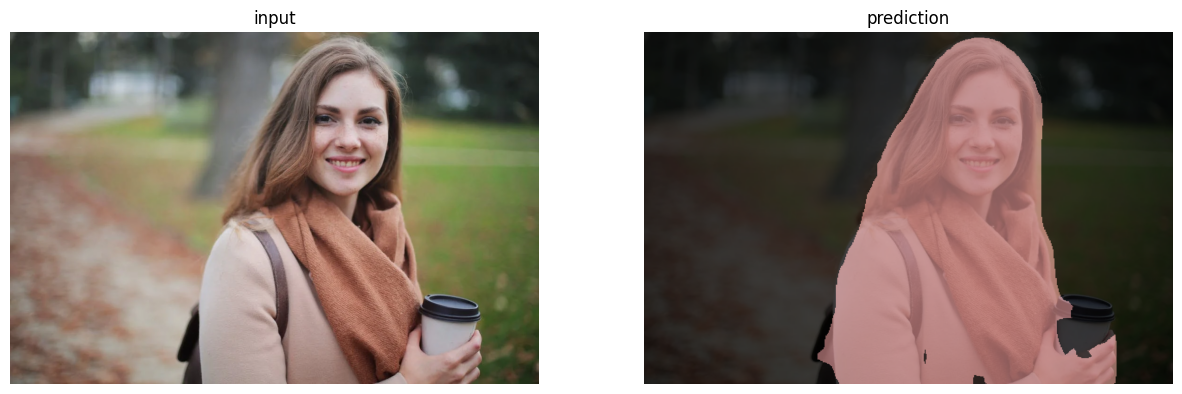

In [18]:
model.eval()
with torch.no_grad():
    target_img = load_image(data_path.joinpath("person.webp"), is_numpy=True)

    h, w, c = target_img.shape
    test_img = test_transform(image=target_img)["image"]
    output = model(test_img.unsqueeze(0).to(DEVICE))
    output = output.argmax(dim=1, keepdim=True)
    # B, C, H, W
    output = F.interpolate(output.float(), size=(h, w), mode="nearest")
    # 1, 1, h, w
    output = output.squeeze(0, 1).detach().cpu().numpy()

    coef = 0.7
    mask = decode_segmap(output, LABEL_COLORS)
    overlay_image = target_img.copy()
    for channel_idx in range(c):
        overlay_image[: , : ,channel_idx] = overlay_image[: , : ,channel_idx] * (1 - coef) + mask[: , : ,channel_idx] * coef


    plot_grids(
        [
            target_img,
            overlay_image,
        ],
        ["input", "prediction"],
        1,
        2,
        figsize=(15, 15),
    )